In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
import fnmatch
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)
            

In [13]:
class Simulation():
    '''Simulation class stores simulation data relevant for NMRlipids project 6'''
    def __init__(self, dirname, 
                 ordpars_fname="OrdPars.dat", 
                 dens_fname="density_ca_cl_water.xvg", 
                 conc_bulk_fname="conc_ion_bulk_mmolL.dat", 
                 conc_nominal_fname="conc_ion_nominal_mmolL.dat"):
        self.dirname = dirname
        self.ordpars = cop.parse_op_input(os.path.join(dirname, ordpars_fname))
        try:
            self.dens    = np.loadtxt(os.path.join(dirname, dens_fname))
            self.conc_bulk = np.loadtxt(os.path.join(dirname, conc_bulk_fname))
            self.conc_nominal = np.loadtxt(os.path.join(dirname, conc_nominal_fname))
        except:
            print "Simulation in \n {d} \n has no densities or files with concentrations, setting concentrations to 0.".format(d=self.dirname)
            self.conc_bulk = np.zeros([2])
            self.conc_nominal = 0.0
                    

Finding all simulations with ECC-lipids and cationic surfactant

In [14]:
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim22a_0mM" in f and "NaCl" in f and "OPC3" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim22_T7H-ECC" in f and "OPC3" in f and not "MODEL_LIPID14" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()
#print sim_dirs

In [15]:
sims = []
for d in sim_dirs:
    sim = Simulation(d)
    sims.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22_T7H-ECC-42p_OPC3_non-tail-atoms_q-sc_0.80_sig-sc_0.89 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_OPC3_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from ECC-lipids simulations

In [16]:
opsdata = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+p_')  # string pattern for molar fraction in %
for s in sims:
    if "T7H" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata.keys():
            opsdata[opname].extend(temp_list)
        else:
            opsdata[opname] = temp_list
            

print opsdata

20.0 -0.03916 0.0012
20.0 -0.03769 0.0012
20.0 -0.07009 0.00117
20.0 -0.06914 0.00117
20.0 65.61806 0.10203
30.0 -0.05375 0.00118
30.0 -0.05438 0.00118
30.0 -0.07613 0.00116
30.0 -0.076 0.00116
30.0 63.61482 0.10402
42.0 -0.07666 0.00124
42.0 -0.07485 0.00124
42.0 -0.08401 0.00124
42.0 -0.08424 0.00124
42.0 61.31964 0.11573
50.0 -0.10275 0.0011
50.0 -0.09888 0.00111
50.0 -0.09341 0.00112
50.0 -0.09232 0.00113
50.0 59.74446 0.11283
0.0 0.00859 0.00111
0.0 0.00926 0.00111
0.0 -0.0459 0.00106
0.0 -0.04657 0.00106
0.0 71.0464 0.08009
{'alpha2': [[20.0, -0.03769], [30.0, -0.05438], [42.0, -0.07485], [50.0, -0.09888], [0.0, 0.00926]], 'alpha1': [[20.0, -0.03916], [30.0, -0.05375], [42.0, -0.07666], [50.0, -0.10275], [0.0, 0.00859]], 'beta2': [[20.0, -0.06914], [30.0, -0.076], [42.0, -0.08424], [50.0, -0.09232], [0.0, -0.04657]], 'beta1': [[20.0, -0.07009], [30.0, -0.07613], [42.0, -0.08401], [50.0, -0.09341], [0.0, -0.0459]], 'PN_vector': [[20.0, 65.61806], [30.0, 63.61482], [42.0, 61.31964]

Redoing the file search again for the reference simulations set (i.e. Lipid14)

In [17]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/POPC+DHMDMAB"):
    sim_dirs.append(os.path.dirname(f))

sim_dirs.sort()
#print sim_dirs

sims_l14 = []
for d in sim_dirs:
    sim = Simulation(d)
    sims_l14.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/0molF 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/10molF 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/20molF 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/30molF 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/42molF 
 has no densities or files with concentrations, setting concentrations to 0.
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/POPC+DHMDMAB/50molF 
 has no densities or files with concentr

getting PN_vector data from Lipid14 simulations

In [18]:
opsdata_l14 = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+molF')  # string pattern for molar fraction in %
for s in sims_l14:
    if "molF" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group().strip("molF"))
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14.keys():
            opsdata_l14[opname].extend(temp_list)
        else:
            opsdata_l14[opname] = temp_list
            

print opsdata_l14

0.0 0.07471 0.00081
0.0 0.07489 0.0008
0.0 0.0032 0.00078
0.0 0.00856 0.00078
0.0 77.86284 0.05334
10.0 0.02858 0.001
10.0 0.03436 0.001
10.0 -0.01796 0.00097
10.0 -0.0149 0.00097
10.0 71.62459 0.0731
20.0 -0.02022 0.00097
20.0 -0.01539 0.00096
20.0 -0.04071 0.00095
20.0 -0.03869 0.00095
20.0 67.91504 0.07955
30.0 -0.05117 0.00093
30.0 -0.04766 0.00093
30.0 -0.05645 0.00094
30.0 -0.05199 0.00094
30.0 63.96344 0.08137
42.0 -0.10377 0.00058
42.0 -0.09798 0.00058
42.0 -0.07771 0.00061
42.0 -0.07918 0.0006
42.0 60.21434 0.05809
50.0 -0.1341 0.00055
50.0 -0.12561 0.00056
50.0 -0.09098 0.00059
50.0 -0.09219 0.00059
50.0 58.28534 0.06027
{'alpha2': [[0.0, 0.07489], [10.0, 0.03436], [20.0, -0.01539], [30.0, -0.04766], [42.0, -0.09798], [50.0, -0.12561]], 'alpha1': [[0.0, 0.07471], [10.0, 0.02858], [20.0, -0.02022], [30.0, -0.05117], [42.0, -0.10377], [50.0, -0.1341]], 'beta2': [[0.0, 0.00856], [10.0, -0.0149], [20.0, -0.03869], [30.0, -0.05199], [42.0, -0.07918], [50.0, -0.09219]], 'beta1': [[

getting experimental results from Scherer89

In [19]:
exp_filenames = []
experiments = {}
freq_to_scd = 0.00748
# find files with the experimental values as read from figure4 in scherer89
for f in locate("sceherer89fig4*C16.dat", root=os.curdir+"/../../../Data"):
    exp_filenames.append(f)
    freq_sign = 1.0
    if "ALPHA" in f:
        op_name = 'alpha'
    elif "BETA" in f:
        op_name = 'beta'
        freq_sign = -1.0
    else:
        print "There's no string >ALPHA< nor >BETA< in file \n {}\n This should not happen, check code...".format(f)
    # load data into numpy array: col0=c, col1=NMR_frequency
    experiments[op_name] = np.loadtxt(f)
    # convert col1 to contain S_CD with a correct sign -- this is specific to these data
    experiments[op_name][:,1] *= freq_to_scd*freq_sign
    # convert col0 to contain concentrations in %-unit
    experiments[op_name][:,0] *= 100.0
    
print experiments
        

{'alpha': array([[ -1.63322445e-01,   8.24615026e-04],
       [  6.21733551e+00,  -1.71978668e-02],
       [  1.19056230e+01,  -2.75345377e-02],
       [  2.00950770e+01,  -4.13117792e-02],
       [  3.12418339e+01,  -6.00641357e-02],
       [  3.80832944e+01,  -8.26977302e-02],
       [  4.24125058e+01,  -9.45839044e-02],
       [  6.47031031e+01,  -1.30165762e-01],
       [  7.05832944e+01,  -1.17426302e-01],
       [  9.12418339e+01,  -1.24178421e-01]]), 'beta': array([[ -1.63322445e-01,  -8.24615026e-04],
       [  3.91682221e+00,  -3.55026998e-03],
       [  9.12389174e+00,  -1.12846977e-02],
       [  1.50104993e+01,  -1.97938771e-02],
       [  2.90398973e+01,  -4.52914972e-02],
       [  4.42172189e+01,  -6.19533331e-02],
       [  6.46237751e+01,  -7.17358976e-02],
       [  9.09420205e+01,  -7.34910873e-02]])}


# Plotting figure 1: PN_vector depends on the amount of bound charge - cationic surfactant

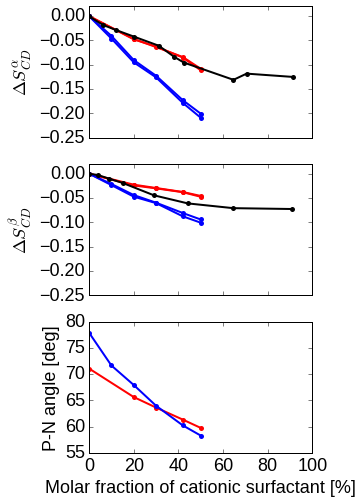

In [20]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=[4,8], dpi=200)
#fig.subplotpars.left = 0.3

# give subplots human-redable names
dsa = axs[0] # Delta S alpha
dsb = axs[1] # Delta S beta
pna = axs[2] # PN_vector

# add some text for labels, title and axes ticks
pna.set_xlabel(r'Molar fraction of cationic surfactant [%]')
pna.set_ylabel(r'P-N angle [deg]')
dsa.set_ylabel(r'$\Delta S_{CD} ^{\alpha}$')
dsb.set_ylabel(r'$\Delta S_{CD} ^{\beta}$')

pna.set_xlim([0.0,100.0])
#ax.set_xticks(r1)
#xlabelsl = list(xlabels)
#xlabelsl.extend(range(2, 18))
#ax.set_xticklabels(xlabelsl, rotation=0)

for opsplot, c in zip([opsdata, opsdata_l14, experiments], ["red", "blue", "black"]):
    for key in opsplot.keys():
        yerror = 0.001
        do_delta = False
        if key.startswith("alpha"):
            iplt = 0
            do_delta = True
            ylim = [-0.25, 0.02]
        elif key.startswith("beta"):
            iplt = 1
            do_delta = True
            ylim = [-0.25, 0.02]
        elif key.startswith("PN"):
            iplt = 2
            yerror = 0.15
            ylim = [55.0, 80.0]
        else:
            print "this should not happen, setting iplt = 2"
            iplt = 2
        ax = axs[iplt]
        ax.set_ylim(ylim)
        if isinstance(opsplot[key], list):
            opsplot[key].sort()
        else:
            #print "this is not list, not sorting. It's likely the experimental data."
            pass
        data = np.array(opsplot[key])
        if do_delta:
            data[:,1] -= data[0,1]
        #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
        ax.plot(data[:,0], data[:,1], lw=2.0, marker='o', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)

#dsa.plot(data[:,0], data[:,1], lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)

#data = np.array(pndata)
#pna.errorbar(data[:,0], data[:,1], yerr=0.15, lw=2.0, marker='s', markersize=5, color="red", label="ECC-lipids") #, c=colour, lw=1.0, label=point_label)
#data_l14 = np.array(pndata_l14)
#pna.errorbar(data_l14[:,0], data_l14[:,1], yerr=0.15, lw=2.0, marker='s', markersize=5, color="blue", label="Lipid14") #, c=colour, lw=1.0, label=point_label)
    
            


#pna.legend(loc="upper right", markerscale=0.5, scatterpoints=4)
plt.savefig("PN_angle_OrdPars-A-B_L14-ECCL17_q80_sig89_surf.eps", dpi=200, bbox_inches='tight')
plt.show()
